# Predicting Financial Time Series Data with Machine Learning

This is a sample that predicts future prices from past price movements.
Here we implement it with EUR/USD rate as an example, but you can convert it to stock price by editing the symbol.


In [44]:
import datetime
import numpy as np
import pandas as pd
# from matplotlib.finance import quotes_historical_yahoo_ochl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display
%matplotlib inline

# time period
d1 = datetime.datetime(2008, 1, 1)
d2 = datetime.datetime(2023, 3, 1)

# Fetching data from yahoo finance
# List of Symbols : http://finance.yahoo.com/webservice/v1/symbols/allcurrencies/quote 
#q = quotes_historical_yahoo_ochl('EUR=X', d1, d2, asobject=True)

/var/folders/js/d6m3lmg13x1dqjyw_1h8pr8h0000gn/T/ipykernel_15855/987440800.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


,DATE,AUD,JPY,NZD,CAD,CHF,EUR,PLN,GBP,MXN,...,jpy_ir,mxn_ir,canada_crude,wti_crude,brent_crude,natural_gas,gold,silver,copper,maya_crude
0,2008-10-31,1.508963,98.320364,1.713778,1.216053,1.156579,0.785374,2.819315,0.618254,12.703598,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
1,2008-11-01,1.508963,98.329552,1.711793,1.215904,1.153206,0.783842,2.819315,0.618169,12.730791,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
2,2008-11-02,1.508963,98.329552,1.711793,1.215904,1.153206,0.783842,2.819315,0.618169,12.730791,...,0.3,8.25,46.31,67.81,60.00,6.783,723.85,9.85,256.3125,50.52
3,2008-11-03,1.475190,98.819425,1.688489,1.190056,1.166273,0.788065,2.775932,0.627786,12.787491,...,0.3,8.25,42.91,63.91,60.32,6.838,723.55,9.84,255.6875,46.93
4,2008-11-04,1.437270,99.755235,1.647282,1.159276,1.164538,0.772049,2.750858,0.626918,12.543740,...,0.3,8.25,49.78,70.53,62.78,7.219,763.27,10.22,268.9375,49.86


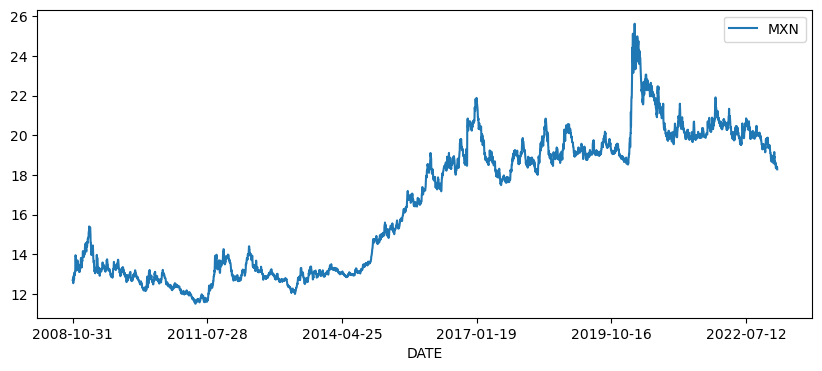

In [46]:
# Put data into Pandas Dataframe
df = pd.read_csv('ml_vf_data.csv')
display(df.head())
df.plot(x='DATE', y='MXN', figsize=(10,4))
#only keep DATE and CAD columns
df = df[['DATE', 'MXN']]
#remove date after 2020
#df = df[df['DATE'] < '2020-01-01']

<AxesSubplot:xlabel='DATE'>

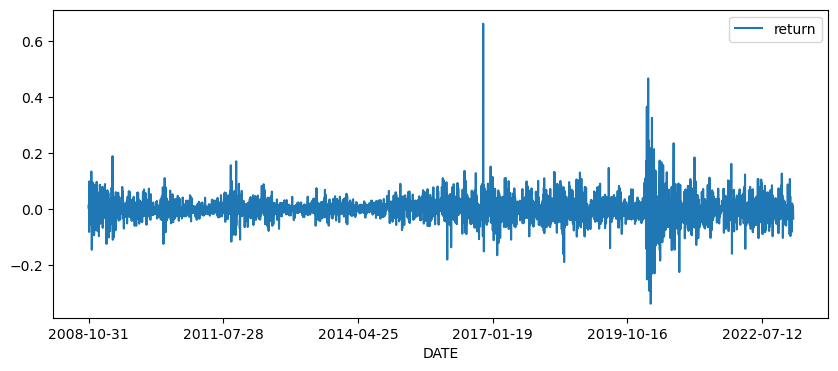

In [34]:
# Normalize aclose value
# We use this value to train model

df['return'] = df['MXN'] - df['MXN'].shift(1)
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

df.plot(x='DATE', y='return', figsize=(10,4))

In [35]:
# Make label, 1 as rising price, 0 as falling price

df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
# df.dropna(inplace=True)
df.tail()

,DATE,MXN,return,label
5228,2023-02-25,18.386800,0.005267,1
5229,2023-02-26,18.387400,0.000204,1
5230,2023-02-27,18.417733,0.010306,0
5231,2023-02-28,18.389283,-0.009667,0
5232,2023-03-01,18.285115,-0.035394,0


In [36]:
n_features = 60 # number of features

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    if i<n_features:
        continue
    
    _x = np.array(df.iloc[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    _y = df.loc[index, 'label']
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))


(5173, 60)
(5173,)
% of Class0 : 0.541272
% of Class1 : 0.458728


In [37]:
# Define Model and fit
# Here we use 95% of data for training, and last 5% for testing

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000)

train_len = int(len(train_x)*0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.552124


,return,label,pred,won,pnl,equity
253,0.015500,1.0,1.0,True,155.00,20852.96
254,0.000600,1.0,0.0,False,-6.00,20846.96
255,0.030333,1.0,1.0,True,303.33,21150.29
256,-0.028450,0.0,1.0,False,-284.50,20865.79
257,-0.104168,0.0,1.0,False,-1041.68,19824.11


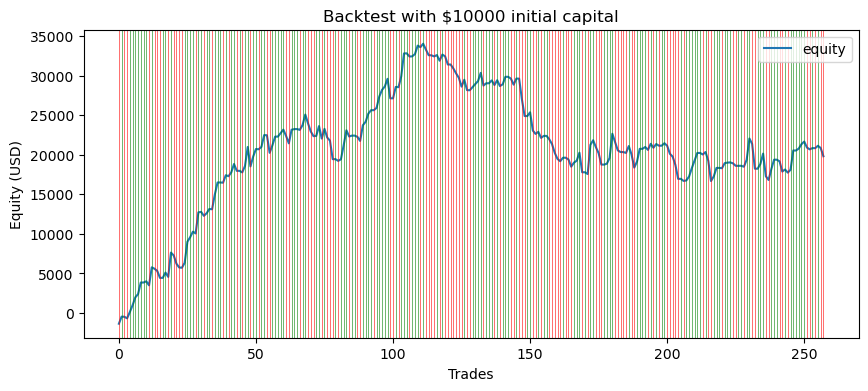

In [38]:
# Predict test data

pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = 10000.0
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')

Net Profit            : $19824.11
Number Winning Trades : 122
Number Losing Trades  : 114
Percent Profitable    : 51.69%
Avg Win Trade         : $852.108
Avg Los Trade         : $-738.009
Largest Win Trade     : $3693.560
Largest Los Trade     : $-3130.000
Profit Factor         : 1.24


<AxesSubplot:>

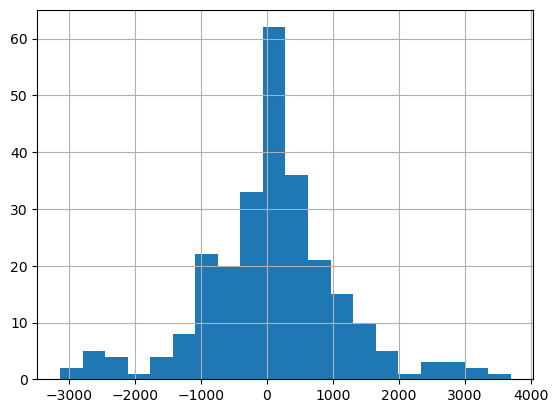

In [39]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)